# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#  Load & Understand Data

In [2]:
df = pd.read_csv('Retail_Dataset2.csv')
print(df.head())

   Product_id  Product_Code Warehouse Product_Category        Date  \
0      786725  Product_0033    Whse_S     Category_005  01/03/2016   
1      786743  Product_1825    Whse_S     Category_006  01/03/2016   
2      786967  Product_0551    Whse_S     Category_030  01/03/2016   
3      786856  Product_0556    Whse_S     Category_030  01/03/2016   
4      899538  Product_1844    Whse_A     Category_018  01/03/2016   

   Order_Demand  Open  Promo StateHoliday  SchoolHoliday  Petrol_price  
0         16000     1      0            0              0            91  
1         50000     1      0            0              0            85  
2          3000     1      0            0              0            85  
3          1000     1      0            0              0            93  
4             7     1      0            0              0            95  


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169211 entries, 0 to 169210
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Product_id        169211 non-null  int64 
 1   Product_Code      169211 non-null  object
 2   Warehouse         169211 non-null  object
 3   Product_Category  169211 non-null  object
 4   Date              169211 non-null  object
 5   Order_Demand      169211 non-null  int64 
 6   Open              169211 non-null  int64 
 7   Promo             169211 non-null  int64 
 8   StateHoliday      169211 non-null  object
 9   SchoolHoliday     169211 non-null  int64 
 10  Petrol_price      169211 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 14.2+ MB
None


# Data Cleaning & Preprocessing

### Handle Duplicates/Missing



In [6]:
df.drop_duplicates(inplace=True)
print(df.isnull().sum())

Product_id          0
Product_Code        0
Warehouse           0
Product_Category    0
Order_Demand        0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Petrol_price        0
dtype: int64


### Aggregate Daily Demand

In [7]:
daily_demand = df.groupby('Date')['Order_Demand'].sum()
daily_demand = daily_demand.asfreq('D')  # set daily frequency
daily_demand = daily_demand.fillna(0)

In [8]:
daily_demand

Date
2016-01-02    5100227.0
2016-01-03    4554147.0
2016-01-04    4658104.0
2016-01-05       1550.0
2016-01-06    4593799.0
                ...    
2016-12-06     100000.0
2016-12-07    3518375.0
2016-12-08    1303160.0
2016-12-09    2512405.0
2016-12-10    3984744.0
Freq: D, Name: Order_Demand, Length: 344, dtype: float64

# Exploratory Data Analysis (EDA)

### Visualize Trends

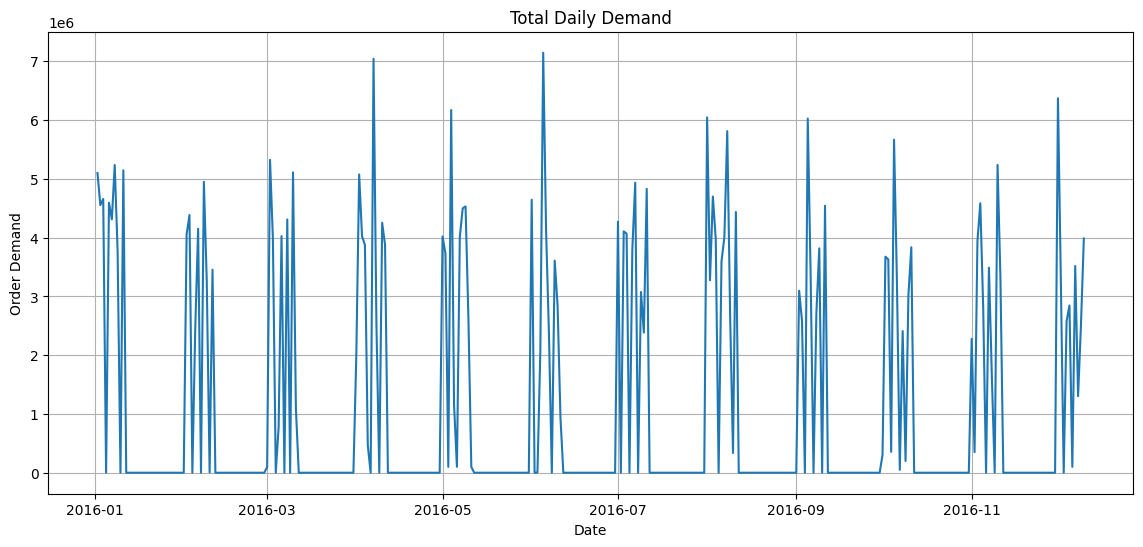

In [9]:
plt.figure(figsize=(14,6))
plt.plot(daily_demand)
plt.title("Total Daily Demand")
plt.xlabel("Date")
plt.ylabel("Order Demand")
plt.grid(True)
plt.show()


### Decompose Series

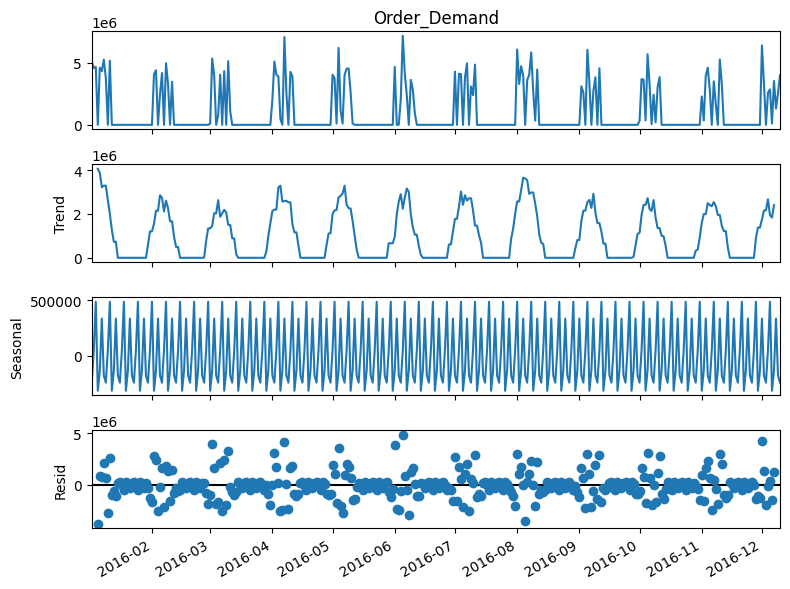

In [20]:
decomposition = seasonal_decompose(daily_demand, model='additive')
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# Stationarity Test

In [11]:
result = adfuller(daily_demand)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.097146060088656
p-value: 1.3296398284441933e-12


# Model Building – ARIMA

In [12]:
model = ARIMA(daily_demand, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                  344
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5407.384
Date:                Sat, 05 Jul 2025   AIC                          10820.768
Time:                        03:54:28   BIC                          10832.282
Sample:                    01-02-2016   HQIC                         10825.354
                         - 12-10-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0389      0.066     -0.590      0.555      -0.168       0.090
ma.L1         -0.6468      0.055    -11.702      0.000      -0.755      -0.538
sigma2      2.992e+12   9.47e-16   3.16e+27      0.0

# Forecasting

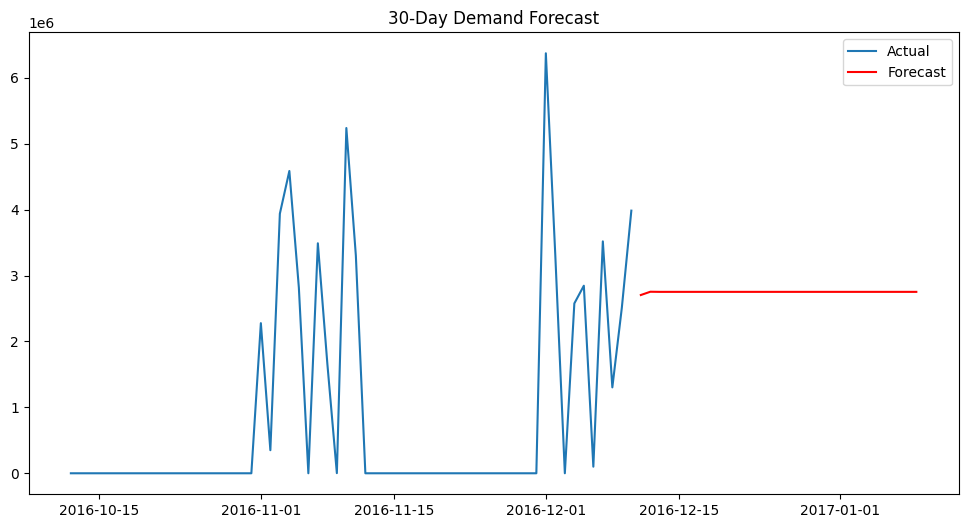

In [13]:
forecast_steps = 30  # 30 days ahead
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12,6))
plt.plot(daily_demand[-60:], label='Actual')
plt.plot(pd.date_range(daily_demand.index[-1]+pd.Timedelta(days=1), periods=forecast_steps), forecast, label='Forecast', color='red')
plt.legend()
plt.title("30-Day Demand Forecast")
plt.show()

# Model Evaluation

In [14]:
train = daily_demand[:-30]
test = daily_demand[-30:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
preds = model_fit.forecast(steps=30)

rmse = np.sqrt(mean_squared_error(test, preds))
print(f"RMSE: {rmse}")

RMSE: 2387893.615128504
